In [1]:
import cmath
import control
from control.matlab import step
import math
import matplotlib.pyplot as plt
import numpy as np

Baseado nas imagens obtidas em sala de aula utilizando a placa confeccionada, temos os valores de tp, delta1 e delta2.

In [2]:
tp = 22.8e-3
delta1 = 104e-3
delta2 = 500e-3

Utilizando as medidas adquiridas utilizando o osciloscópio, podemos calcular as variáveis de interesse.

Mp =  0.208
zeta =  0.4470816765034814
Wn =  154.04159693070577

        2.373e+04
-------------------------
s^2 + 137.7 s + 2.373e+04



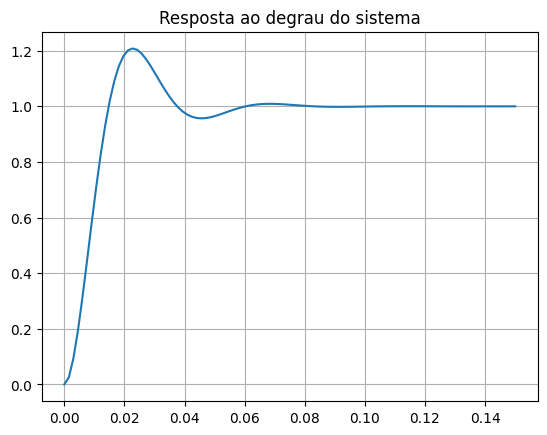

In [3]:
Mp = delta1/delta2

zeta = np.sqrt((np.log(Mp)**2)/(((np.pi)**2)+np.log(Mp)**2))

Wn = (np.pi)/(tp*np.sqrt(1-zeta**2))

print("Mp = ", Mp)
print("zeta = ", zeta)
print("Wn = ", Wn)


num = Wn**2
den = [1,2*zeta*Wn,Wn**2]

G1 = control.tf(num,den)

print(G1)

xf, yf = control.step_response(G1, 0.15)
plt.title("Resposta ao degrau do sistema")
plt.grid()
plt.plot(xf,yf)

Sobressinal percentual

In [4]:
Mp = (max(yf)-yf[-1])/(yf[-1]-yf[0])*100
print(f'Mp = {Mp:.2f}%')

Mp = 20.80%


Ts5%

In [5]:
ts5 = 3/(zeta * Wn)
print("ts5 = ", ts5)

ts5 =  0.04356085262047068


Especificações do projeto

In [6]:
Ts5 = len('EricMonteiroDosReis')*1e-3
Mp = (2*len('Eric'))/100
print("Ts5% = ", Ts5)
print("Mp do projeto = ", Mp)

Ts5% =  0.019
Mp do projeto =  0.08


In [7]:
zeta2 = np.sqrt(np.log(Mp)**2/((np.pi**2) + (np.log(Mp)**2)))
print("Zeta = ", zeta2)

Wn = 3/(zeta2 * Ts5)
print("Wn = ", Wn)

Zeta =  0.6265771868559205
Wn =  251.99566813850933


In [8]:
sample_cycle = 10            #amostras por ciclo
wd = Wn*np.sqrt(1-zeta2**2)

ws = sample_cycle*wd
T = (2*np.pi)/ws
print(f'T = {T*1e3:.4f} ms')

T = 3.1993 ms


Controlador digital pelo método do lugar das raízes

In [9]:
Z_module = math.e**(-T*zeta2*Wn)
Z_phase_rad = T*Wn*np.sqrt(1-zeta2**2)
Z_phase_deg = math.degrees(Z_phase_rad)

z1 = cmath.rect(Z_module, Z_phase_rad)

print(f'z1 = |{Z_module:.4f}|<{Z_phase_deg:.4f}°')
print(z1)

z1 = |0.6034|<36.0000°
(0.48817512033201993+0.3546799860353469j)


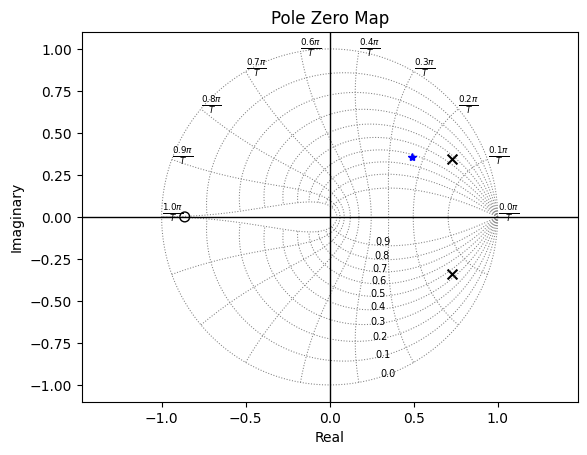

In [10]:
# Conversao da planta para o dominio z
G1z = control.c2d(G1,T)
control.pzmap(G1z, True, True)

plt.plot(z1.real, z1.imag, '*b')
plt.show()

In [11]:
#zeros do controlador
Cz = control.tf(G1z.den[0][0], 1, T)

#integrador
Ci = control.tf(1,[1, -1], T) 

#junta o integrador + zeros do controlador
Gc = Cz * Ci 

angle = np.pi - cmath.phase(Gc(z1)) - cmath.phase(G1z(z1))

print(f'Angulo faltante para completar 180°: {math.degrees(angle):.4f}°')

Angulo faltante para completar 180°: -49.4338°


In [12]:
# Formula para o cálculo de beta fornecida pelo professor nos slides de Exemplo de cálculo alternativo da condição de ângulo para determinar o polo do controlador.   
beta = (z1.imag - z1.real * math.tan(-angle))/math.tan(-angle)
print(beta)

-0.1845401776166611


In [13]:
Cp = control.tf([1], [1, beta], T)

print(f'Gc = {Cp*Cz}')

FTMA_no_gain = Cp*Gc*G1z
print(FTMA_no_gain)
math.degrees(cmath.phase(FTMA_no_gain(z1)))

Gc = 
z^2 - 1.451 z + 0.6436
----------------------
      z - 0.1845

dt = 0.003199256282790456


0.1033 z^3 - 0.06083 z^2 - 0.06284 z + 0.05737
----------------------------------------------
z^4 - 2.636 z^3 + 2.547 z^2 - 1.03 z + 0.1188

dt = 0.003199256282790456



179.99999999999994

In [14]:
K = 1/np.abs(FTMA_no_gain(z1))

FTMA = K * FTMA_no_gain

print(f'K = {K}')

K = 2.0144240238962596


Equação recursiva

In [15]:
Controler = K*Cp*Gc

print(f'C = {Controler}\nG = {G1z}')

C = 
2.014 z^2 - 2.923 z + 1.297
---------------------------
  z^2 - 1.185 z + 0.1845

dt = 0.003199256282790456

G = 
  0.1033 z + 0.08914
----------------------
z^2 - 1.451 z + 0.6436

dt = 0.003199256282790456



In [16]:
FTMFz = FTMA/(1 + FTMA)

yc, tc =step(FTMFz, T*np.arange(0,int(0.05/T + 1)))

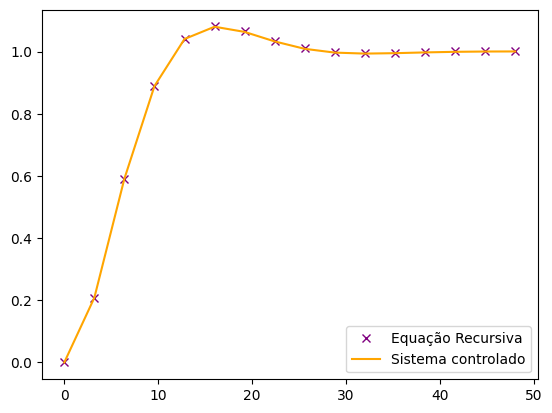

In [18]:
kmax = int(0.05/T + 1)
tk = T*np.arange(0,kmax)
Ref = 1
yk = np.zeros(kmax)
u = np.zeros(kmax)
e = Ref - yk

u[0] = 2.014*e[0]
yk[1] = 0.1033*u[0] +1.451*yk[0] 
e[1] = Ref - yk[1]
u[1] = 2.014*e[1] -2.923*e[0] +1.185*u[0]

for k in range(2, kmax):
    yk[k] = 0.1033*u[k-1] +1.451*yk[k-1] +0.08914*u[k-2] -0.6436*yk[k-2]
    e[k] = Ref - yk[k]
    u[k] = 2.014*e[k] -2.923*e[k-1] +1.185*u[k-1] +1.297*e[k-2] -0.1845*u[k-2]

plt.plot(tk*1e3, yk, 'x', color='purple', label="Equação Recursiva")
plt.plot(tc*1e3, yc, color='orange', label= "Sistema controlado")
plt.legend()
plt.show()

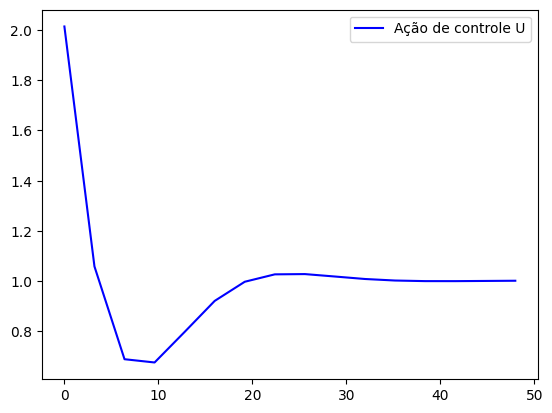

In [32]:
plt.plot(tc*1e3, u, color='blue', label= "Ação de controle U")
plt.legend()
plt.show()

Utilizando a função max nas amostras, podemos calcular o valor de Mp

In [28]:
print(f'Mp simulado = {(max(yk)-1)*100}%')

Mp simulado = 8.081025957507105%


In [20]:
yk

array([0.        , 0.2080462 , 0.59075482, 0.88884117, 1.0407818 ,
       1.08081026, 1.06470405, 1.03445402, 1.01077017, 0.99861159,
       0.99530407, 0.99644781, 0.99872952, 1.00051853, 1.00142716,
       1.00166647])

Observamos que no array acima o primeiro valor discreto que se aproxima do valor de Ts5% (observando no sentido reverso o array) é o sétimo índice do array, contendo o valor 1.06470405. Multiplicando esse valor pelo período de amostragem, podemos obter nosso valor de Ts5% a partir das equações recursivas.

In [27]:
6*T

0.01919553769674274